In [137]:
%matplotlib inline

import os

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from botorch.utils.transforms import standardize, normalize, unnormalize
from botorch.acquisition import ExpectedImprovement, UpperConfidenceBound, ProbabilityOfImprovement
from scipy import linalg
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PathToSubmol, FindAtomEnvironmentOfRadiusN, MolToSmiles
from rdkit.Chem.AtomPairs import Pairs
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from map4 import MAP4Calculator

## Read dataset

In [2]:
mhci = pd.read_csv('binding_data_2013/bdata.20130222.mhci.csv')

In [30]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (mhci['length'] == 9) &
            (~mhci['affinity_binding'].isin(dirty_values))]

In [66]:
data = []
AA = []

with open('IEDB_MHC_I-2.9_matx_smm_smmpmbec/smm_matrix/HLA-A-02:01-9.txt') as f:
    lines = f.readlines()
    
    for line in lines[1:-1]:
        sline = line.strip().split('\t')
        AA.append(sline[0])
        data.append([float(v) for v in sline[1:]])

columns = list(range(1, 10))
pssm = pd.DataFrame(data=data, columns=columns, index=AA)

## Correlation between PSSM and exp. values

In [67]:
pssm_scores = []

for peptide in mhci.itertuples():
    score = 0
    
    for i, aa in enumerate(peptide.sequence):
        score += pssm.loc[aa][i + 1]
    
    pssm_scores.append(score)
    
pssm_scores = np.array(pssm_scores)

R2: 0.644


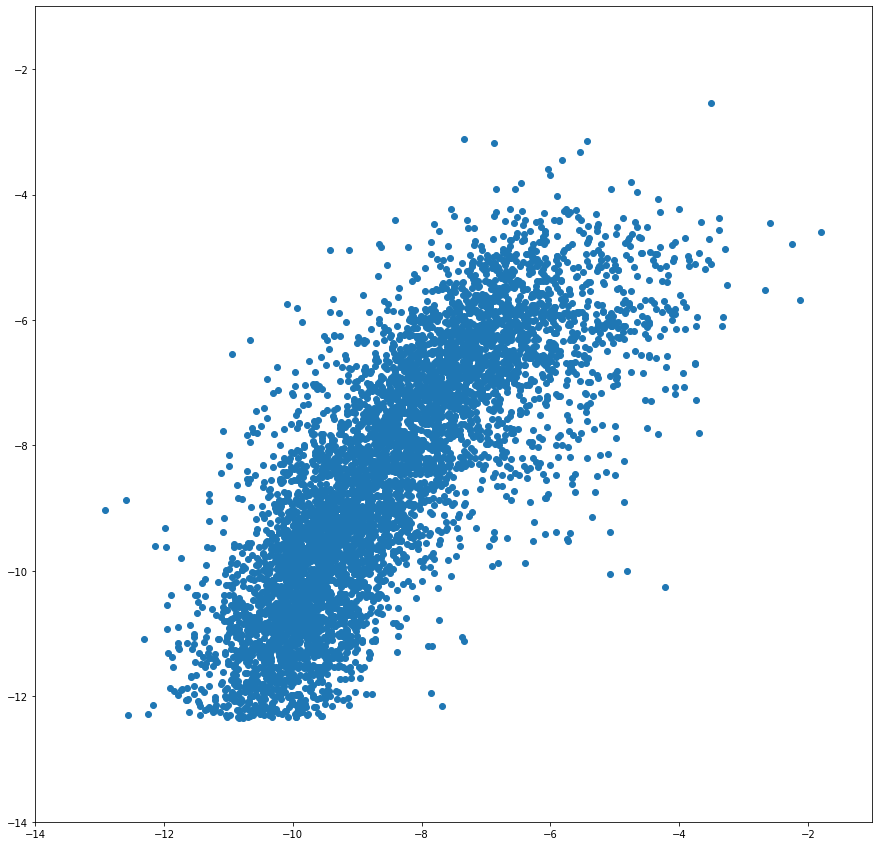

In [68]:
# Fit PSSM score to exp. values
reg = LinearRegression()
reg.fit(pssm_scores[:,None], mhci['energy'])
print('R2: %.3f' % reg.score(pssm_scores[:,None], mhci['energy']))

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(reg.predict(pssm_scores[:,None]), mhci['energy'])
ax.set_xlim([-14, -1])
ax.set_ylim([-14, -1])
plt.show()

In [69]:
temperature = 300.
RT = 0.001987 * temperature
RT * np.log(500 * 1e-9)

-8.648610877934287

In [124]:
def score_peptides(sequences, pssm, reg, cutoff=-8.5):
    scores = []
    
    for sequence in sequences:
        score = 0
        
        for i, aa in enumerate(sequence):
            score += pssm.loc[aa][i + 1]
        
        scores.append(score)
    
    pred_scores = reg.predict(np.array(scores)[:,None])
    pred_scores[pred_scores > cutoff] = 0.
    
    return pred_scores

In [123]:
score_peptides(['FFFFFFFFY', 'FFFFFFFFA'], pssm, reg)

array([  0.       , -10.0157568])

## Bayesian opt.

In [347]:
class TanimotoSimilarityKernel(gpytorch.kernels.Kernel):
    # the sequence kernel is stationary
    is_stationary = True     

    # this is the kernel function
    def forward(self, x1, x2, diag=False, last_dim_is_batch=False, **params):
        if last_dim_is_batch:
            # Not tested
            x1 = x1.transpose(-1, -2).unsqueeze(-1)
            x2 = x2.transpose(-1, -2).unsqueeze(-1)

        x1_eq_x2 = torch.equal(x1, x2)
        
        x1s = torch.sum(torch.square(x1), dim=-1)
        x2s = torch.sum(torch.square(x2), dim=-1)
        
        if diag:
            if x1_eq_x2:
                res = torch.ones(*x1.shape[:-2], x1.shape[-2], dtype=x1.dtype, device=x1.device)
                return res
            else:
                product = torch.mul(x1, x2).sum(dim=1)
                denominator = torch.add(x2s, x1s) - product
        else:
            product = torch.mm(x1, x2.transpose(1, 0))
            denominator = torch.add(x2s, x1s[:, None]) - product

        res = product / denominator
        
        return res

    
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP, GPyTorchModel):
    # to inform GPyTorchModel API
    _num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood, kernel=None):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        if kernel is not None:
            self.covar_module = gpytorch.kernels.ScaleKernel(kernel())
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(TanimotoSimilarityKernel())

        # make sure we're on the right device/dtype
        self.to(train_x)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    
def get_fitted_model(train_x, train_y, state_dict=None, kernel=None):
    # initialize and fit model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood, kernel)
    
    if state_dict is not None:
        model.load_state_dict(state_dict)
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    mll.to(train_x)
    
    # Train model!
    fit_gpytorch_model(mll)
    
    return model

In [348]:
def predict(model, likelihood, test_x):
    model.eval()
    likelihood.eval()
    
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))


def plot(y_test, observed_pred, fig_filename=None):
    with torch.no_grad():
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        
        ax.scatter(y_test, observed_pred)
        
        ax.set_xlim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_ylim([np.min([y_test, observed_pred]) - 1, np.max([y_test, observed_pred]) + 1])
        ax.set_xlabel('Experimental values (kcal/mol)', fontsize=20)
        ax.set_ylabel('Predicted values (kcal/mol)', fontsize=20)
        
        if fig_filename is not None:
            plt.savefig(fig_filename, bbox_inches='tight', dpi=300)
        
        plt.show()

In [369]:
def expected_improvement(model, Y_train, Xsamples, greater_is_better=False, xi=0.00):
    """ expected_improvement
    Expected improvement acquisition function.
    
    Source: https://github.com/thuijskens/bayesian-optimization/blob/master/python/gp.py
    
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.
        xi: Exploitation-exploration trade-off parameter

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()

    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)

    # calculate the expected improvement
    Z = scaling_factor * (mu - loss_optimum - xi) / (sigma + 1E-9)
    ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + (sigma * norm.pdf(Z))
    ei[sigma == 0.0] == 0.0

    return -1 * ei


# probability of improvement acquisition function
def probability_of_improvement(model, Y_train, Xsamples, greater_is_better=False):
    """ probability_of_improvement
    Probability of improvement acquisition function.
        
    Arguments:
    ----------
        model: Gaussian process model
        Y_train: Array that contains all the observed energy interaction seed so far
        X_samples: Samples we want to try out
        greater_is_better: Indicates whether the loss function is to be maximised or minimised.

    """
    # calculate mean and stdev via surrogate function
    observed_pred = predict(model, model.likelihood, Xsamples)
    sigma = observed_pred.variance.sqrt().detach().numpy()
    mu = observed_pred.mean.detach().numpy()
    
    if greater_is_better:
        loss_optimum = np.max(Y_train.numpy())
    else:
        loss_optimum = np.min(Y_train.numpy())

    scaling_factor = (-1) ** (not greater_is_better)
    
    # calculate the probability of improvement
    Z = scaling_factor * (mu - loss_optimum) / (sigma + 1E-9)
    pi = norm.cdf(Z)
    pi[sigma == 0.0] == 0.0
    
    return pi

## MAP4 fingerprint + tanimoto kernel

In [398]:
def map4_fingerprint(sequences, dimensions=4096, radius=2, is_counted=False, is_folded=True):
    MAP4_unf = MAP4Calculator(dimensions=dimensions, radius=radius, is_counted=is_counted, is_folded=is_folded)
    fps = MAP4_unf.calculate_many([Chem.rdmolfiles.MolFromFASTA(s) for s in sequences])
    return torch.from_numpy(np.array(fps)).float()

In [399]:
class PBIL(object):
    def __init__(self, model, acq_fun, y_exp, peptide_length=9, population_size=96,
                 n_best=48, learning_rate=0.5, sigma=0.25, mut_prob=0.0, mut_shift=0.00,
                 seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        self._model = model
        self._acq_fun = acq_fun
        self._y_exp = y_exp
        
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._sigma = sigma
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size
        
        # Elitism
        self._best_score = 0.

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)
    
    def evaluate(self, individual):
        MAP4_unf = MAP4Calculator(dimensions=4096, radius=2, is_counted=False, is_folded=True)
        fps = MAP4_unf.calculate(Chem.rdmolfiles.MolFromFASTA(''.join(individual)))
        individual = torch.from_numpy(np.array(fps)).float()[None,:]
        return self._acq_fun(self._model, self._y_exp, individual)[0],
    
    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])

        best_peptide_indices = np.argsort(np.ravel(scores))[::-1][:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:
                if scores[best_peptide_indices[0]] > self._best_score:
                    self._best_score = scores[best_peptide_indices[0]]
                
                """
                if not np.all(scores[best_peptide_indices] == self._best_score):
                    # Normalize the scores between 0 (best score so far) and the worst in this serie
                    norm_scores = self._best_score - scores[best_peptide_indices]
                    print(norm_scores)
                    norm_scores /= self._best_score - np.max(scores[best_peptide_indices])
                    
                    print(norm_scores)

                    # Use the radial basis function (RBF) kernel
                    # Closest the score is from the best score, greater will be its weight
                    weights = np.exp(-norm_scores**2 / (2 * self._sigma**2))
                else:
                    # All the peptides got the same score as the best score
                    weights = np.array([1] * len(best_peptides[:,i]))
                """
                
                weights = np.array([1] * len(best_peptides[:,i]))
                
                # Inverse the order
                # For this position, put the best peptide at the end
                # When updating the probability vector, the last one has more impact 
                # then the first sequence
                weights = np.flip(weights)
                amino_acids = np.flip(best_peptides[:,i])
                
            else:
                # When we choose only one best peptide for updating the probability vector
                amino_acids = [best_peptides[0][i]]
                weights = [1.]
            
            for amino_acid, weight in zip(amino_acids, weights):
                j = self._AA1.index(amino_acid)
                
                # Update the probability vector
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += weight * self._learning_rate

                # Mutate the probability vector
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])

In [424]:
def find_next_candidates(model, acq_fun, y_exp):
    NGEN = 10
    NIND = 200
    NLEN = 9
    NCAN = 96

    #Initialize the PBIL EDA
    pbil = PBIL(model, acq_fun, y_exp, peptide_length=NLEN, population_size=NIND, n_best=100)

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", pbil.evaluate)
    toolbox.register("generate", pbil.generate, creator.Individual)
    toolbox.register("update", pbil.update)

    # Statistics computation
    hof = tools.HallOfFame(NCAN)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)

    #plot_logbook(logbook, minimum_score)
    
    candidates = [''.join(s) for s in hof.items]

    return candidates

In [445]:
random_peptides = []
random_peptide_scores = []

while True:
    p = ''.join(np.random.choice(pssm.index, 9))
    s = score_peptides([p], pssm, reg)[0]
    
    if -9.5 <= s <= -8.5:
        random_peptides.append(p)
        random_peptide_scores.append(s)
    
    if len(random_peptides) == 150:
        break
        
random_peptides = np.array(random_peptides)
random_peptide_scores = np.array(random_peptide_scores)

In [446]:
# Compute the MAP4 fingerprint for all the peptides
X_fps_exp = map4_fingerprint(random_peptides)
y_exp = torch.from_numpy(random_peptide_scores).float()

print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))

Exp dataset size: (150, 4096)


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


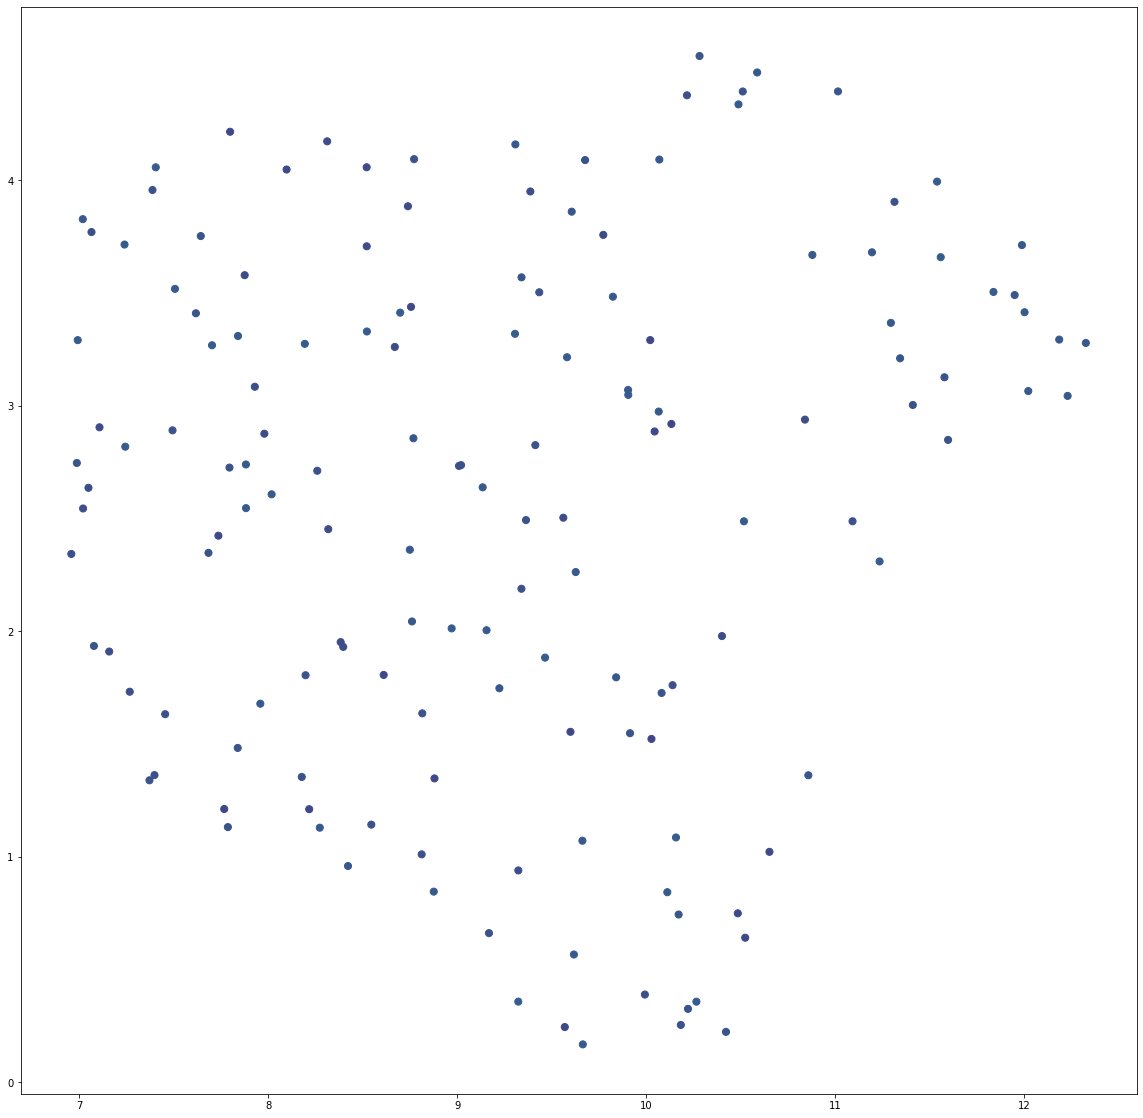

In [447]:
k = TanimotoSimilarityKernel()
mat = 1. - k.forward(X_fps_exp, X_fps_exp)

fit = umap.UMAP(n_neighbors=10, min_dist=0.1, metric='precomputed')
u = fit.fit_transform(mat)

fig, ax = plt.subplots(figsize=(20, 20))
ax.scatter(u[:,0], u[:,1], s=50, c=y_exp.numpy(), vmin=-12, vmax=0)
plt.show()

In [448]:
print('Init.')
print('Train: ', X_fps_exp.shape[0])
print('Pool : ', X_fps_exp.shape[0])
print('Best peptide: %.3f' % y_exp.min())
for n in [-12, -11, -10, -9, -8]:
    print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
print('Non binding pep               : %03d' % (y_exp[y_exp == 0.].shape[0]))
    
print('\n\n')

for i in range(3):
    print(i + 1)
    model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)
    
    candidates = find_next_candidates(model, probability_of_improvement, y_exp)
    
    candidate_fps = map4_fingerprint(candidates)
    y_candidates = torch.from_numpy(np.array(score_peptides(candidates, pssm, reg)))
    
    X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
    y_exp = torch.cat([y_exp, y_candidates])
    
    """
    fig, axarr = plt.subplots(1, 2, figsize=(20, 10))
    axarr[0].scatter(u[:,0], u[:,1], s=5, c=y.numpy(), vmin=-12, vmax=0)
    axarr[0].scatter(u[:,0][train_ids], u[:,1][train_ids], s=20, c='red')
    axarr[1].scatter(u[:,0][candidates_ids], u[:,1][candidates_ids], s=20, c=y.numpy()[candidates_ids], vmin=-12, vmax=0)
    
    axarr[0].set_title('Training', fontsize=20)
    axarr[1].set_title('Candidates', fontsize=20)
    axarr[0].set_xlim(xlim)
    axarr[0].set_ylim(ylim)
    axarr[1].set_xlim(xlim)
    axarr[1].set_ylim(ylim)
    
    plt.show()
    """
    
    print('Train: ', X_fps_exp.shape[0])
    print('Pool : ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9, -8]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep               : %03d' % (y_exp[y_exp == 0.].shape[0]))
    
    print('\n\n')

Init.
Train:  150
Pool :  150
Best peptide: -9.500
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 052
N pep under -8 kcal/mol: 150
Non binding pep               : 000



1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std     	min       	max     
0  	200   	0.0169166	0.014193	0.00151464	0.114174
1  	200   	0.0180801	0.0144571	0.0011763 	0.0735361
2  	200   	0.0174105	0.0142708	0.000748153	0.0755003
3  	200   	0.0186256	0.0185568	0.000673245	0.199922 
4  	200   	0.0170582	0.0149291	0.00116572 	0.0988324
5  	200   	0.0214987	0.0198348	0.0010462  	0.114001 
6  	200   	0.023729 	0.0238104	0.00147154 	0.202935 
7  	200   	0.0228814	0.0220941	0.00114304 	0.141851 
8  	200   	0.0222608	0.0182821	0.000573545	0.0942705
9  	200   	0.0197887	0.0155074	0.00116931 	0.0935027
Train:  246
Pool :  246
Best peptide: -10.704
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 005
N pep under -9 kcal/mol: 066
N pep under -8 kcal/mol: 170
Non binding pep               : 076



2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std      	min        	max     
0  	200   	0.0898685	0.0905511	0.000618159	0.454852
1  	200   	0.104276 	0.0843842	0.00378418 	0.394954
2  	200   	0.109191 	0.0923119	0.00237098 	0.591367
3  	200   	0.12956  	0.0977886	0.00467234 	0.544608
4  	200   	0.138413 	0.101862 	0.00776501 	0.494332
5  	200   	0.137942 	0.0971022	0.00673071 	0.523223
6  	200   	0.145791 	0.101148 	0.00655476 	0.537556
7  	200   	0.140804 	0.091563 	0.00452666 	0.498431
8  	200   	0.139833 	0.0914895	0.00509934 	0.492743
9  	200   	0.147711 	0.0953601	0.00575494 	0.497456
Train:  342
Pool :  342
Best peptide: -11.600
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 001
N pep under -10 kcal/mol: 009
N pep under -9 kcal/mol: 079
N pep under -8 kcal/mol: 197
Non binding pep               : 145



3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std      	min        	max     
0  	200   	0.0331478	0.0370326	0.000949998	0.233655
1  	200   	0.0336707	0.0357844	0.000583251	0.197578
2  	200   	0.0410474	0.0417253	0.0017525  	0.214196
3  	200   	0.0403085	0.0505576	0.000501565	0.380104
4  	200   	0.0390926	0.0488066	0.000643567	0.371248
5  	200   	0.0420625	0.0414989	0.000224171	0.200023
6  	200   	0.0448233	0.0472453	0.00103715 	0.316397
7  	200   	0.0469479	0.0506146	0.000530176	0.291307
8  	200   	0.0479273	0.0584753	0.00153369 	0.510445
9  	200   	0.051331 	0.0542779	0.0028903  	0.319034
Train:  438
Pool :  438
Best peptide: -11.707
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 020
N pep under -9 kcal/mol: 127
N pep under -8 kcal/mol: 259
Non binding pep               : 179





## DPPS descriptors + RBF kernel

In [370]:
def transform(sequences, scale):    
    transformed = []
    
    for seq in sequences:
        tmp = []

        for aa in seq:
            tmp.extend(scale[scale['AA1'] == aa].values[0][2:])

        transformed.append(tmp)
        
    return torch.from_numpy(np.array(transformed)).float()

In [371]:
class PBIL(object):
    def __init__(self, model, acq_fun, y_exp, peptide_length=9, population_size=96,
                 n_best=48, learning_rate=0.5, sigma=0.25, mut_prob=0.0, mut_shift=0.00,
                 seed=None):
        self._AA1 = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I',
                     'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']
        self._model = model
        self._acq_fun = acq_fun
        self._y_exp = y_exp
        self._descriptors = pd.read_csv('extended_dpps.csv')
        
        # Random generation
        self._random_seed = seed
        self._rng = np.random.default_rng(self._random_seed)

        # Initialize probability vectors
        n_amino_acids = len(self._AA1)
        self._peptide_length = peptide_length
        init_probability = 1. / n_amino_acids
        self._prob_vector = np.zeros(shape=(peptide_length, n_amino_acids)) + init_probability

        # PBIL parameters
        self._sigma = sigma
        self._n_best = n_best
        self._learning_rate = learning_rate
        self._mut_prob = mut_prob
        self._mut_shift = mut_shift
        self._population_size = population_size
        
        # Elitism
        self._best_score = 0.

    def sample(self):
        ind = [self._rng.choice(self._AA1, p=self._prob_vector[i]) for i in range(self._peptide_length)]
        return (ind)
    
    def evaluate(self, individual):
        individual = transform([''.join(individual)], self._descriptors)
        return self._acq_fun(self._model, self._y_exp, individual)[0],
    
    def generate(self, ind_init):
        return [ind_init(self.sample()) for _ in range(self._population_size)]

    def update(self, population, scores=None):
        if scores is None:
            scores = np.array([ind.fitness.values[0] for ind in population])

        best_peptide_indices = np.argsort(np.ravel(scores))[::-1][:self._n_best]
        best_peptides = np.array(population)[best_peptide_indices]
        
        for i in range(self._peptide_length):
            if self._n_best > 1:
                if scores[best_peptide_indices[0]] > self._best_score:
                    self._best_score = scores[best_peptide_indices[0]]
                
                # Inverse the order
                # For this position, put the best peptide at the end
                # When updating the probability vector, the last one has more impact 
                # then the first sequence
                weights = np.flip(np.array([1] * len(best_peptides[:,i])))
                amino_acids = np.flip(best_peptides[:,i])
                
            else:
                # When we choose only one best peptide for updating the probability vector
                amino_acids = [best_peptides[0][i]]
                weights = [1.]
            
            for amino_acid, weight in zip(amino_acids, weights):
                j = self._AA1.index(amino_acid)
                
                # Update the probability vector
                self._prob_vector[i, j] *= 1.0 - self._learning_rate
                self._prob_vector[i, j] += weight * self._learning_rate

                # Mutate the probability vector
                if self._rng.uniform() < self._mut_prob:
                    self._prob_vector[i, j] *= 1.0 - self._mut_shift
                    self._prob_vector[i, j] += self._rng.uniform() * self._mut_shift
            
            # Normalize vector
            self._prob_vector[i] /= np.sum(self._prob_vector[i])

In [372]:
def find_next_candidates(model, acq_fun, y_exp):
    NGEN = 10
    NIND = 200
    NLEN = 9

    #Initialize the PBIL EDA
    pbil = PBIL(model, acq_fun, y_exp, peptide_length=NLEN, population_size=NIND, n_best=100, learning_rate=0.5)

    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("evaluate", pbil.evaluate)
    toolbox.register("generate", pbil.generate, creator.Individual)
    toolbox.register("update", pbil.update)

    # Statistics computation
    hof = tools.HallOfFame(NIND)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, logbook = algorithms.eaGenerateUpdate(toolbox, NGEN, stats=stats, verbose=True, halloffame=hof)

    #plot_logbook(logbook, minimum_score)
    
    candidates = [''.join(s) for s in hof.items]

    return candidates

In [391]:
random_peptides = np.random.choice(pssm.index, (3000, 9))
random_peptides = [''.join(p) for p in random_peptides]

In [392]:
random_peptide_scores = score_peptides(random_peptides, pssm, reg)

In [393]:
i = np.argsort(random_peptide_scores)[:150]
random_peptide_scores = random_peptide_scores[i]
random_peptides = np.array(random_peptides)[i]

print(random_peptide_scores)

[-12.1375481  -11.31431856 -10.79820717 -10.76634844 -10.677144
 -10.42354852 -10.36492846 -10.28591882 -10.25788314 -10.24896269
 -10.18014784 -10.13936867 -10.0909434  -10.07437686 -10.01193376
 -10.00556201 -10.00173896  -9.99154417  -9.9533137   -9.93419846
  -9.92655236  -9.86665796  -9.84244532  -9.77235612  -9.76853307
  -9.76471003  -9.69844387  -9.67805429  -9.66785949  -9.66531079
  -9.61433683  -9.61306248  -9.59777029  -9.58120375  -9.56081417
  -9.55316807  -9.53277849  -9.53022979  -9.52513239  -9.51876064
  -9.50601715  -9.48180452  -9.46906103  -9.44102535  -9.43337925
  -9.41171532  -9.39514878  -9.37858224  -9.36583875  -9.36329005
  -9.35564396  -9.33015697  -9.31231609  -9.30212129  -9.2944752
  -9.27918301  -9.26898822  -9.23967819  -9.23075774  -9.23075774
  -9.22948339  -9.2218373   -9.2218373   -9.21164251  -9.19889901
  -9.144102    -9.144102    -9.13390721  -9.13390721  -9.12116372
  -9.09949978  -9.08548194  -9.08293324  -9.08293324  -9.08165889
  -9.0714641 

In [394]:
descriptors = pd.read_csv('extended_dpps.csv')

# Compute the MAP4 fingerprint for all the peptides
X_fps_exp = transform(random_peptides, descriptors)
y_exp = torch.from_numpy(random_peptide_scores).float()

print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))

Exp dataset size: (150, 90)


In [395]:
print('Init.')
print('Train: ', X_fps_exp.shape[0])
print('Pool : ', X_fps_exp.shape[0])
print('Best peptide: %.3f' % y_exp.min())
for n in [-12, -11, -10, -9]:
    print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
print('Non binding pep               : %03d' % (y_exp[y_exp == 0.].shape[0]))
    
print('\n\n')


for i in range(3):
    print(i + 1)
    model = get_fitted_model(X_fps_exp, y_exp, kernel=gpytorch.kernels.RBFKernel)
    
    candidates = find_next_candidates(model, probability_of_improvement, y_exp)
    
    candidate_fps = transform(candidates, descriptors)
    y_candidates = torch.from_numpy(np.array(score_peptides(candidates, pssm, reg)))
    
    X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
    y_exp = torch.cat([y_exp, y_candidates])
    
    """
    fig, axarr = plt.subplots(1, 2, figsize=(20, 10))
    axarr[0].scatter(u[:,0], u[:,1], s=5, c=y.numpy(), vmin=-12, vmax=0)
    axarr[0].scatter(u[:,0][train_ids], u[:,1][train_ids], s=20, c='red')
    axarr[1].scatter(u[:,0][candidates_ids], u[:,1][candidates_ids], s=20, c=y.numpy()[candidates_ids], vmin=-12, vmax=0)
    
    axarr[0].set_title('Training', fontsize=20)
    axarr[1].set_title('Candidates', fontsize=20)
    axarr[0].set_xlim(xlim)
    axarr[0].set_ylim(ylim)
    axarr[1].set_xlim(xlim)
    axarr[1].set_ylim(ylim)
    
    plt.show()
    """
    
    print('Train: ', X_fps_exp.shape[0])
    print('Pool : ', X_fps_exp.shape[0])
    print('Best peptide: %.3f' % y_exp.min())
    for n in [-12, -11, -10, -9]:
        print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
    print('Non binding pep               : %03d' % (y_exp[y_exp == 0.].shape[0]))
    
    print('\n\n')

Init.
Train:  150
Pool :  150
Best peptide: -12.138
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 017
N pep under -9 kcal/mol: 082
Non binding pep               : 004



1


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std        	min      	max      
0  	200   	0.0242872	3.46945e-18	0.0242872	0.0242872
1  	200   	0.0242872	3.46945e-18	0.0242872	0.0242872
2  	200   	0.0242872	3.46945e-18	0.0242872	0.0242872
3  	200   	0.0242872	3.46945e-18	0.0242872	0.0242872
4  	200   	0.0242872	3.46945e-18	0.0242872	0.0242872
5  	200   	0.0242872	3.46945e-18	0.0242872	0.0242872
6  	200   	0.0242872	3.46945e-18	0.0242872	0.0242872
7  	200   	0.0242872	3.46945e-18	0.0242872	0.0242872
8  	200   	0.0242872	3.46945e-18	0.0242872	0.0242872
9  	200   	0.0242872	3.46945e-18	0.0242872	0.0242872
Train:  350
Pool :  350
Best peptide: -12.138
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 002
N pep under -10 kcal/mol: 017
N pep under -9 kcal/mol: 085
Non binding pep               : 199



2


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std        	min      	max      
0  	200   	0.0374452	6.93889e-18	0.0374452	0.0374452
1  	200   	0.0374452	6.93889e-18	0.0374452	0.0374452
2  	200   	0.0374452	6.93889e-18	0.0374452	0.0374452
3  	200   	0.0374452	6.93889e-18	0.0374452	0.0374452
4  	200   	0.0374452	6.93889e-18	0.0374452	0.0374452
5  	200   	0.0374452	6.93889e-18	0.0374452	0.0374452
6  	200   	0.0374452	6.93889e-18	0.0374452	0.0374452
7  	200   	0.0374452	6.93889e-18	0.0374452	0.0374452
8  	200   	0.0374452	6.93889e-18	0.0374452	0.0374452
9  	200   	0.0374452	6.93889e-18	0.0374452	0.0374452
Train:  550
Pool :  550
Best peptide: -12.138
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 003
N pep under -10 kcal/mol: 019
N pep under -9 kcal/mol: 093
Non binding pep               : 389



3


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg     	std        	min     	max     
0  	200   	0.012624	3.46945e-18	0.012624	0.012624
1  	200   	0.012624	3.46945e-18	0.012624	0.012624
2  	200   	0.012624	3.46945e-18	0.012624	0.012624
3  	200   	0.012624	3.46945e-18	0.012624	0.012624
4  	200   	0.012624	3.46945e-18	0.012624	0.012624
5  	200   	0.012624	3.46945e-18	0.012624	0.012624
6  	200   	0.012624	3.46945e-18	0.012624	0.012624
7  	200   	0.012624	3.46945e-18	0.012624	0.012624
8  	200   	0.012624	3.46945e-18	0.012624	0.012624
9  	200   	0.012624	3.46945e-18	0.012624	0.012624
Train:  750
Pool :  750
Best peptide: -12.138
N pep under -12 kcal/mol: 001
N pep under -11 kcal/mol: 004
N pep under -10 kcal/mol: 020
N pep under -9 kcal/mol: 099
Non binding pep               : 577



